In [1]:
import os
import math
import time
import datetime
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams ['font.sans-serif'] ='SimHei'              #显示中文
plt.rcParams ['axes.unicode_minus']=False               #显示负号
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,Conv1D,CuDNNGRU, MaxPooling1D,GlobalMaxPooling1D,Embedding,Dropout,Flatten,SimpleRNN,LSTM
from keras.callbacks import EarlyStopping
#from tensorflow.keras import regularizers
#from keras.utils.np_utils import to_categorical
from tensorflow.keras  import optimizers

In [3]:

"""Relevance Vector Machine classes for regression and classification."""
from scipy.optimize import minimize
from scipy.special import expit
 
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (
    linear_kernel,
    rbf_kernel,
    polynomial_kernel
)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y
 
class BaseRVM(BaseEstimator):
 
    """Base Relevance Vector Machine class.
    Implementation of Mike Tipping's Relevance Vector Machine using the
    scikit-learn API. Add a posterior over weights method and a predict
    in subclass to use for classification or regression.
    """
 
    def __init__(
        self,
        kernel='rbf',
        degree=3,
        coef1=None,
        coef0=0.0,
        n_iter=6000,
        tol=1e-3,
        alpha=1e-6,
        threshold_alpha=1e9,
        beta=1.e-6,
        beta_fixed=False,
        bias_used=True,
        verbose=False
    ):
        """Copy params to object properties, no validation."""
        self.kernel = kernel
        self.degree = degree
        self.coef1 = coef1
        self.coef0 = coef0
        self.n_iter = n_iter
        self.tol = tol
        self.alpha = alpha
        self.threshold_alpha = threshold_alpha
        self.beta = beta
        self.beta_fixed = beta_fixed
        self.bias_used = bias_used
        self.verbose = verbose
 
    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = {
            'kernel': self.kernel,
            'degree': self.degree,
            'coef1': self.coef1,
            'coef0': self.coef0,
            'n_iter': self.n_iter,
            'tol': self.tol,
            'alpha': self.alpha,
            'threshold_alpha': self.threshold_alpha,
            'beta': self.beta,
            'beta_fixed': self.beta_fixed,
            'bias_used': self.bias_used,
            'verbose': self.verbose
        }
        return params
 
    def set_params(self, **parameters):
        """Set parameters using kwargs."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
 
    def _apply_kernel(self, x, y):
        """Apply the selected kernel function to the data."""
        if self.kernel == 'linear':
            phi = linear_kernel(x, y)
        elif self.kernel == 'rbf':
            phi = rbf_kernel(x, y, self.coef1)
        elif self.kernel == 'poly':
            phi = polynomial_kernel(x, y, self.degree, self.coef1, self.coef0)
        elif callable(self.kernel):
            phi = self.kernel(x, y)
            if len(phi.shape) != 2:
                raise ValueError(
                    "Custom kernel function did not return 2D matrix"
                )
            if phi.shape[0] != x.shape[0]:
                raise ValueError(
                    "Custom kernel function did not return matrix with rows"
                    " equal to number of data points."""
                )
        else:
            raise ValueError("Kernel selection is invalid.")
 
        if self.bias_used:
            phi = np.append(phi, np.ones((phi.shape[0], 1)), axis=1)
 
        return phi
 
    def _prune(self):
        """Remove basis functions based on alpha values."""
        keep_alpha = self.alpha_ < self.threshold_alpha
 
        if not np.any(keep_alpha):
            keep_alpha[0] = True
            if self.bias_used:
                keep_alpha[-1] = True
 
        if self.bias_used:
            if not keep_alpha[-1]:
                self.bias_used = False
            self.relevance_ = self.relevance_[keep_alpha[:-1]]
        else:
            self.relevance_ = self.relevance_[keep_alpha]
 
        self.alpha_ = self.alpha_[keep_alpha]
        self.alpha_old = self.alpha_old[keep_alpha]
        self.gamma = self.gamma[keep_alpha]
        self.phi = self.phi[:, keep_alpha]
        self.sigma_ = self.sigma_[np.ix_(keep_alpha, keep_alpha)]
        self.m_ = self.m_[keep_alpha]
 
    def fit(self, X, y):
        """Fit the RVR to the training data."""
        X, y = check_X_y(X, y)
 
        n_samples, n_features = X.shape
 
        self.phi = self._apply_kernel(X, X)
 
        n_basis_functions = self.phi.shape[1]
 
        self.relevance_ = X
        self.y = y
 
        self.alpha_ = self.alpha * np.ones(n_basis_functions)
        self.beta_ = self.beta
 
        self.m_ = np.zeros(n_basis_functions)
 
        self.alpha_old = self.alpha_
 
        for i in range(self.n_iter):
            self._posterior()
 
            self.gamma = 1 - self.alpha_*np.diag(self.sigma_)
            self.alpha_ = self.gamma/(self.m_ ** 2)
 
            if not self.beta_fixed:
                self.beta_ = (n_samples - np.sum(self.gamma))/(
                    np.sum((y - np.dot(self.phi, self.m_)) ** 2))
 
            self._prune()
 
            if self.verbose:
                print("Iteration: {}".format(i))
                print("Alpha: {}".format(self.alpha_))
                print("Beta: {}".format(self.beta_))
                print("Gamma: {}".format(self.gamma))
                print("m: {}".format(self.m_))
                print("Relevance Vectors: {}".format(self.relevance_.shape[0]))
                print()
 
            delta = np.amax(np.absolute(self.alpha_ - self.alpha_old))
 
            if delta < self.tol and i > 1:
                break
 
            self.alpha_old = self.alpha_
 
        if self.bias_used:
            self.bias = self.m_[-1]
        else:
            self.bias = None
 
        return self
 
class RVR(BaseRVM, RegressorMixin):
 
    """Relevance Vector Machine Regression.
    Implementation of Mike Tipping's Relevance Vector Machine for regression
    using the scikit-learn API.
    """
 
    def _posterior(self):
        """Compute the posterior distriubtion over weights."""
        i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
        self.sigma_ = np.linalg.inv(i_s)
        self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))
 
    def predict(self, X, eval_MSE=False):
        """Evaluate the RVR model at x."""
        phi = self._apply_kernel(X, self.relevance_)
 
        y = np.dot(phi, self.m_)
 
        if eval_MSE:
            MSE = (1/self.beta_) + np.dot(phi, np.dot(self.sigma_, phi.T))
            return y, MSE[:, 0]
        else:
            return y

In [22]:
data_path = '../data/A榜-训练集_海上风电预测_气象变量及实际功率数据.csv'
data0=pd.read_csv(data_path,encoding='gbk',nrows=57960/10,encoding_errors='ignore').iloc[:,2:].rename(columns={'出力(MW)':'y'})
data0.head()

,气压(Pa）,相对湿度（%）,云量,10米风速（10m/s）,10米风向（°),温度（K）,辐照强度（J/m2）,降水（m）,100m风速（100m/s）,100m风向（°),y
0,102249.6094,74.8513,0.007812,7.7041,26.5195,286.0695,0.0,0.000008,9.0820,27.5093,17.26
1,102252.0355,74.7530,0.000924,7.7710,23.5766,285.8647,0.0,0.000008,9.1374,24.7151,16.78
2,102248.5900,74.4995,0.003009,7.8272,21.5451,285.6935,0.0,0.000008,9.1856,22.7445,16.25
3,102240.4725,74.1432,0.011402,7.8637,20.2394,285.5512,0.0,0.000008,9.2158,21.4374,15.37
4,102228.8828,73.7366,0.023438,7.8781,19.4870,285.4330,0.0,0.000008,9.2237,20.6417,15.64


In [23]:
data0.fillna(0,inplace=True)
data0['y'] = data0['y'].replace('<NULL>', 0.0).astype(float)
data0['y'] = data0['y'].apply(lambda x:max(0.0,x))

In [24]:
X=data0.iloc[:,:-1]  ; y=data0.iloc[:,-1]
scaler_s = StandardScaler()
scaler_s.fit(X)
X_s = scaler_s.transform(X)

In [25]:
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(12345)
    tf.random.set_seed(123)
    
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    r_2=r2_score(y_test, y_predict)
    score = 1/(1+rmse)
    return mae, rmse, mape,r_2, score #mse

In [26]:
#构建RVM模型
rvm_model_linear = RVR(kernel="linear")
rvm_model_linear.fit(X_s, y)
print(rvm_model_linear.score(X_s, y))
 
rvm_model_rbf = RVR(kernel="rbf")
rvm_model_rbf.fit(X_s, y)
print(rvm_model_rbf.score(X_s, y))
 
rvm_model_poly = RVR(kernel="poly")
rvm_model_poly.fit(X_s, y)
print(rvm_model_poly.score(X_s, y))

0.6886406846123704
0.9202931538071725
0.7092451612071962


In [27]:
def build_sequences(text, window_size=24):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]
        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
 
def get_traintest(data,train_size=len(data0),window_size=24):
    train=data[:train_size]
    test=data[train_size-window_size:]
    X_train,y_train=build_sequences(train,window_size=window_size)
    X_test,y_test=build_sequences(test,window_size=window_size)
    return X_train,y_train,X_test,y_test

In [28]:
def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    if mode=='RNN':
        #RNN
        model.add(SimpleRNN(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(SimpleRNN(hidden_dim[1]))     
        
    elif mode=='MLP':
        model.add(Dense(hidden_dim[0],activation='relu',input_shape=(X_train.shape[-1],)))
        model.add(Dense(hidden_dim[1],activation='relu'))
        
    elif mode=='LSTM':
        # LSTM
        model.add(LSTM(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(LSTM(hidden_dim[1]))
    elif mode=='GRU':
        #GRU
        model.add(GRU(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(GRU(hidden_dim[1]))
    elif mode=='CuDNNGRU':
        # CuDNNGRU
        model.add(GRU(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(GRU(hidden_dim[1]))
    
    elif mode=='CNN':
        #一维卷积
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=2))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=4))
        #GlobalMaxPooling1D()
        model.add(Flatten())
        
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model
 
def plot_loss(hist,imfname):
    plt.subplots(1,4,figsize=(16,2))
    for i,key in enumerate(hist.history.keys()):
        n=int(str('14')+str(i+1))
        plt.subplot(n)
        plt.plot(hist.history[key], 'k', label=f'Training {key}')
        plt.title(f'{imfname} Training {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.legend()
    plt.tight_layout()
    plt.show()
def plot_fit(y_test, y_pred,name):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"{name}拟合值和真实值对比")
    plt.xlabel("Time")
    plt.ylabel(name)
    plt.legend()
    plt.show()

In [29]:
def train_fuc(mode='LSTM',window_size=64,batch_size=32,epochs=50,hidden_dim=[32,16],train_ratio=0.8,kernel="rbf",show_loss=True,show_fit=True):
    df_eval_all=pd.DataFrame(columns=['MAE','RMSE','MAPE','R2','score'])
    df_preds_all=pd.DataFrame()
    df_preds=pd.DataFrame()
    #预测每一列
    for i,col_name in  enumerate(data0.columns):
        if col_name != 'y': continue
        print(f'正在处理变量：{col_name}')
        #准备数据
        data=data0[col_name]
        train_size=int(len(data)*train_ratio)
        X_train,y_train,X_test,y_test=get_traintest(data.values,window_size=window_size,train_size=train_size)
        #print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        #归一化
        scaler = MinMaxScaler() 
        scaler = scaler.fit(X_train)
        X_train=scaler.transform(X_train)   ;   X_test=scaler.transform(X_test)
 
        y_train_orage=y_train.copy()    ;       y_scaler = MinMaxScaler() 
        y_scaler = y_scaler.fit(y_train.reshape(-1,1))
        y_train=y_scaler.transform(y_train.reshape(-1,1))
        
        if mode!='MLP':
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        #构建模型
        s = time.time()
        set_my_seed()
        if col_name == '降水（m）----------':
            print("降水调用lstm..............")
            model=build_model(X_train=X_train,mode='LSTM',hidden_dim=hidden_dim)
        else:
            model=build_model(X_train=X_train,mode=mode,hidden_dim=hidden_dim)
        earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5)
        hist=model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,callbacks=[earlystop],verbose=0)
        if show_loss:
            plot_loss(hist,col_name)
            
        #预测
        y_pred = model.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred)
        #print(f'真实y的形状：{y_test.shape},预测y的形状：{y_pred.shape}')
        if show_fit:
            plot_fit(y_test, y_pred,name=col_name)
        e=time.time()
        print(f"运行时间为{round(e-s,3)}")
        df_preds[col_name]=y_pred.reshape(-1,)
        
        s=list(evaluation(y_test, y_pred))
        s=[round(i,3) for i in s]
        print(f'{col_name}变量的预测效果为：MAE:{s[0]},RMSE:{s[1]},MAPE:{s[2]},R2:{s[3]},SCORE:{s[4]}')
        print("=================================================================================")
        
        
    X_pred=df_preds.iloc[:,:-1]
    X_pred_s = scaler_s.transform(X_pred)
    y_direct=df_preds.iloc[:,-1]  
    
    if kernel=="rbf":
        y_nodirect=rvm_model_rbf.predict(X_pred_s)
    if kernel=="linear":
        y_nodirect=rvm_model_linear.predict(X_pred_s)        
    if kernel=="ploy":
        y_nodirect=rvm_model_ploy.predict(X_pred_s) 
        
    score1=list(evaluation(y_test, y_direct))
    score2=list(evaluation(y_test, y_nodirect))
    df_preds_all[mode]=y_direct
    df_preds_all[f'{mode}+RVM']=y_nodirect
    df_eval_all.loc[f'{mode}',:]=score1
    df_eval_all.loc[f'{mode}+RVM',:]=score2
    print(score2)

In [30]:
window_size=96*2

batch_size=48

epochs=800

hidden_dim=[32,16]

train_ratio=0.8

kernel="rbf"

show_fit=True

show_loss=True

mode='LSTM'  #RNN,GRU,CNN

正在处理变量：y


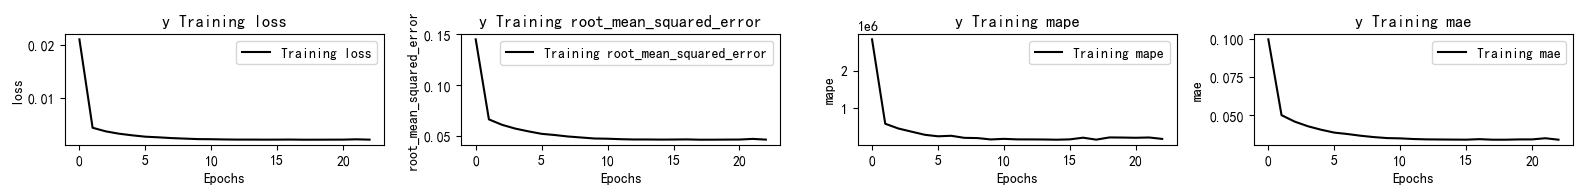

37/37 [==============================] - 2s 22ms/step


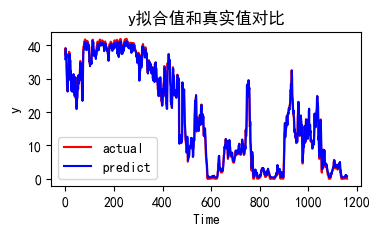

运行时间为253.248
y变量的预测效果为：MAE:1.113,RMSE:1.641,MAPE:inf,R2:0.988,SCORE:0.379


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_16968\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()
E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: at least one array or dtype is required

In [31]:
mode='GRU'
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim)

In [ ]:
mode='LSTM' 
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=32,epochs=epochs,hidden_dim=hidden_dim)

正在处理变量：气压(Pa）


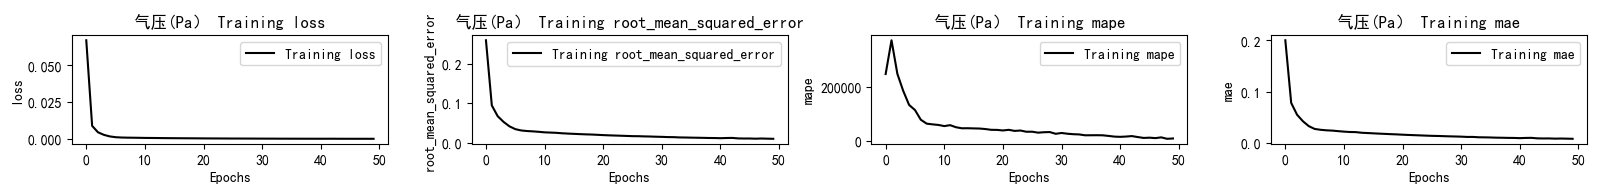

6/6 [==============================] - 1s 13ms/step


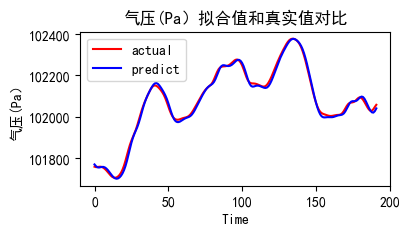

运行时间为34.613
气压(Pa）变量的预测效果为：MAE:8.592,RMSE:10.262,MAPE:0.002,R2:0.996
正在处理变量：相对湿度（%）


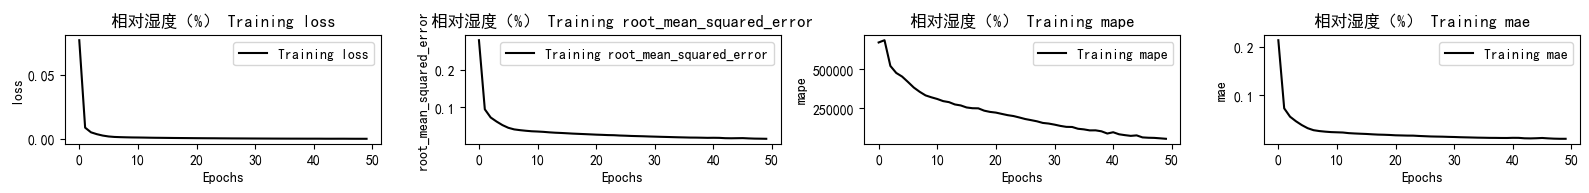

6/6 [==============================] - 1s 9ms/step


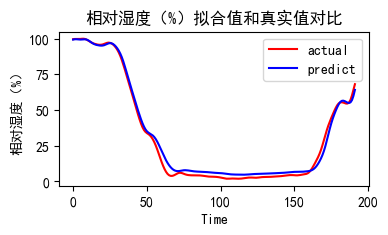

运行时间为31.877
相对湿度（%）变量的预测效果为：MAE:2.525,RMSE:3.079,MAPE:5.288,R2:0.993
正在处理变量：云量


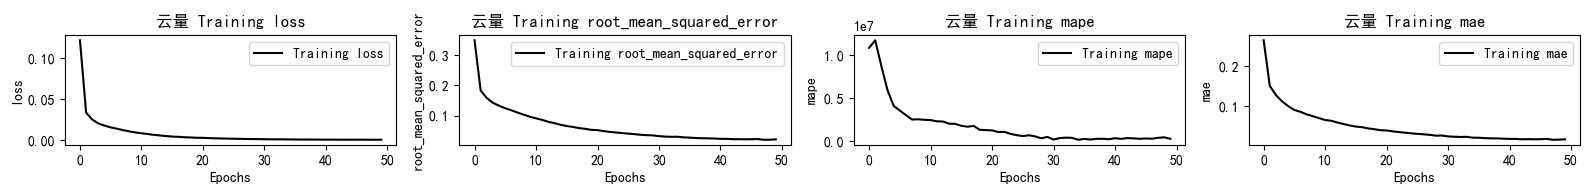

6/6 [==============================] - 1s 9ms/step


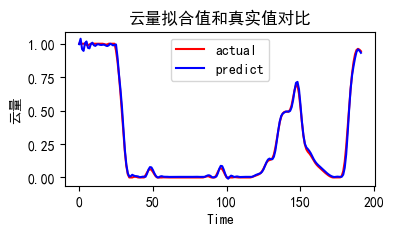

运行时间为29.731
云量变量的预测效果为：MAE:0.01,RMSE:0.014,MAPE:inf,R2:0.999
正在处理变量：10米风速（10m/s）


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\859237441.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


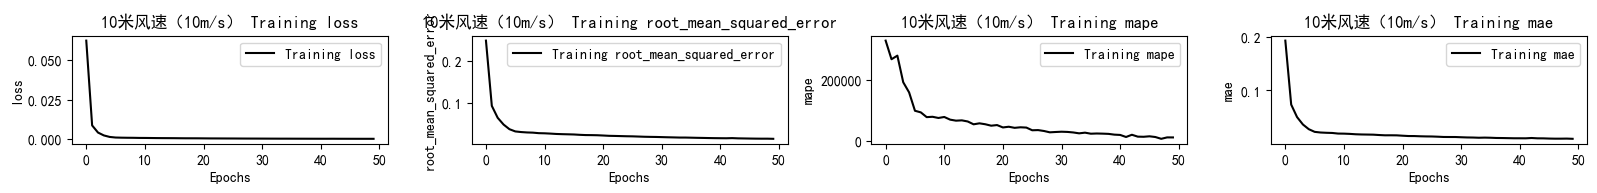

6/6 [==============================] - 1s 9ms/step


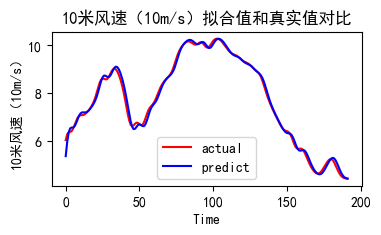

运行时间为30.227
10米风速（10m/s）变量的预测效果为：MAE:0.09,RMSE:0.126,MAPE:0.29,R2:0.995
正在处理变量：10米风向（°)


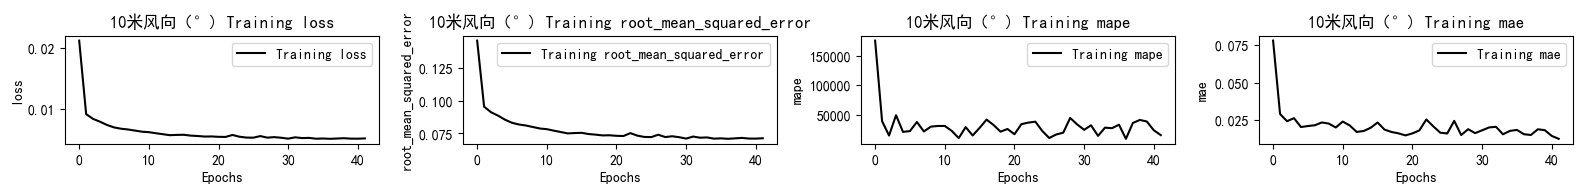

6/6 [==============================] - 1s 12ms/step


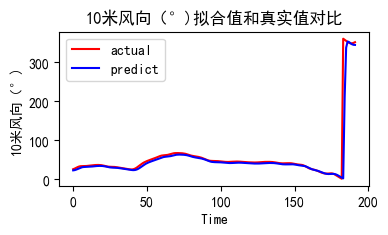

运行时间为29.648
10米风向（°)变量的预测效果为：MAE:5.329,RMSE:28.016,MAPE:1.002,R2:0.826
正在处理变量：温度（K）


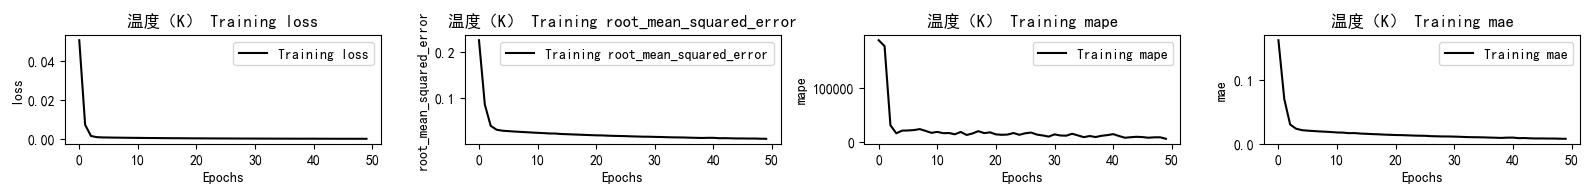

6/6 [==============================] - 1s 10ms/step


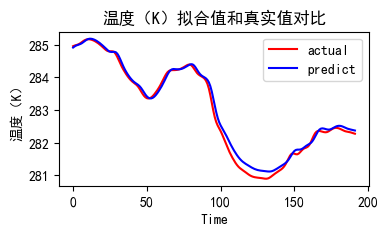

运行时间为33.926
温度（K）变量的预测效果为：MAE:0.104,RMSE:0.139,MAPE:0.006,R2:0.99
正在处理变量：辐照强度（J/m2）


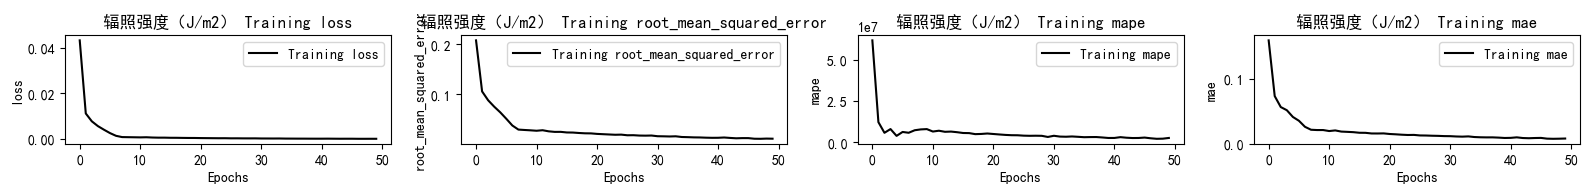

6/6 [==============================] - 2s 21ms/step


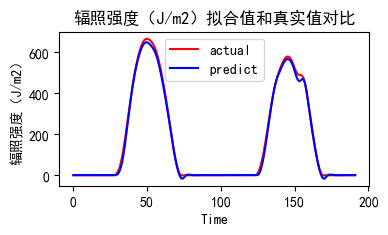

运行时间为35.15
辐照强度（J/m2）变量的预测效果为：MAE:6.639,RMSE:10.057,MAPE:inf,R2:0.998
正在处理变量：降水（m）


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\859237441.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


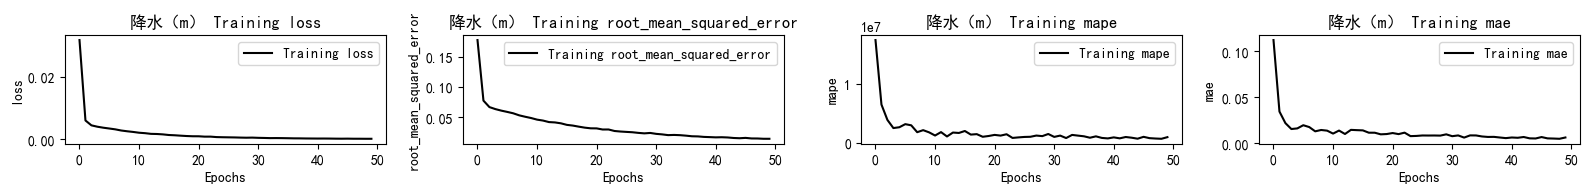

6/6 [==============================] - 1s 11ms/step


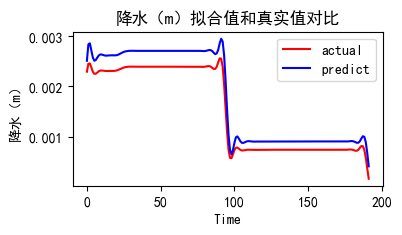

运行时间为42.855
降水（m）变量的预测效果为：MAE:0.0,RMSE:0.0,MAPE:0.976,R2:0.9
正在处理变量：100m风速（100m/s）


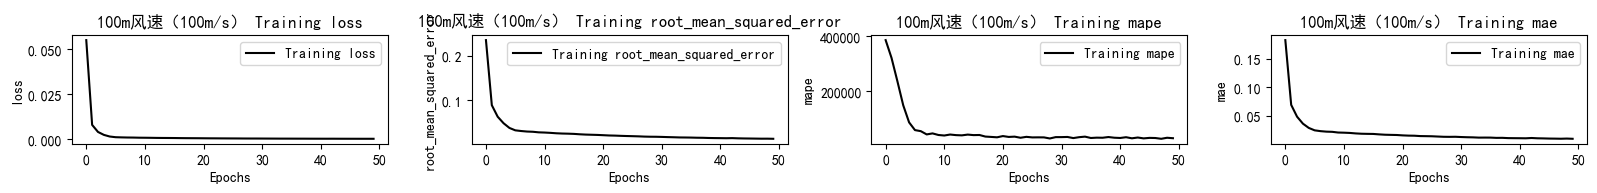

6/6 [==============================] - 1s 10ms/step


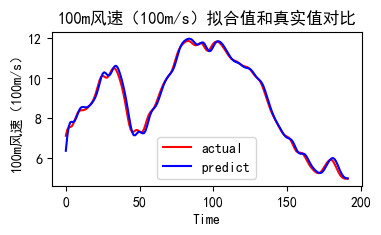

运行时间为44.302
100m风速（100m/s）变量的预测效果为：MAE:0.108,RMSE:0.148,MAPE:0.305,R2:0.995
正在处理变量：100m风向（°)


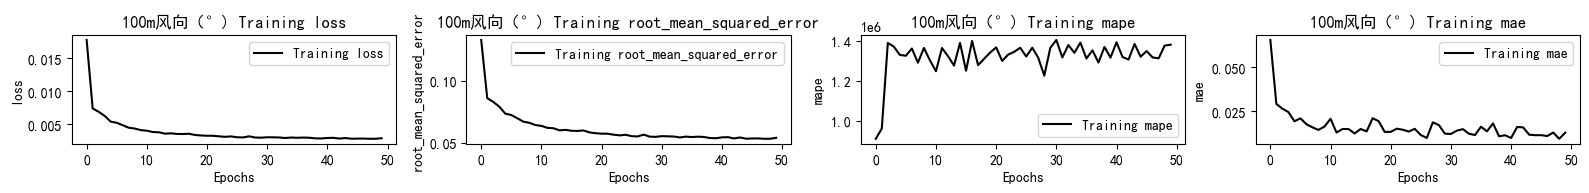

6/6 [==============================] - 1s 10ms/step


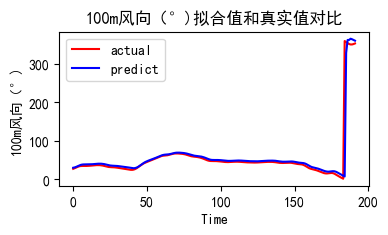

运行时间为34.049
100m风向（°)变量的预测效果为：MAE:5.742,RMSE:25.825,MAPE:1.104,R2:0.837
正在处理变量：y


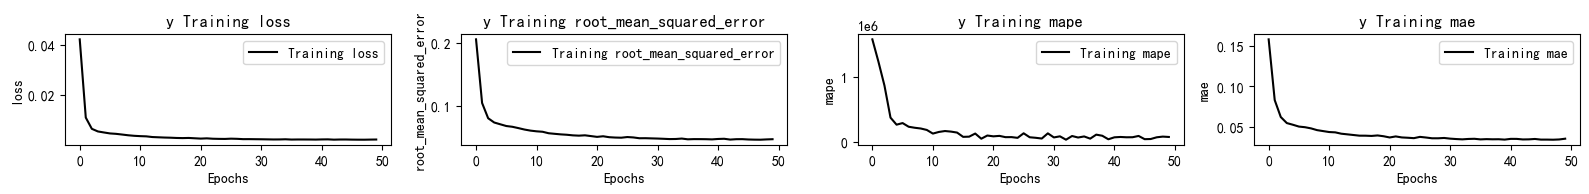

6/6 [==============================] - 1s 9ms/step


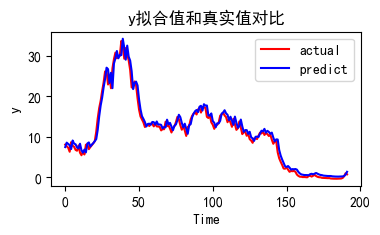

运行时间为30.776
y变量的预测效果为：MAE:1.027,RMSE:1.331,MAPE:9.117,R2:0.973
[1.3470940151545279, 1.72862888318145, 0.7230700271914428, 0.9552556944025347]


In [22]:
mode='GRU' 
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim)

正在处理变量：气压(Pa）


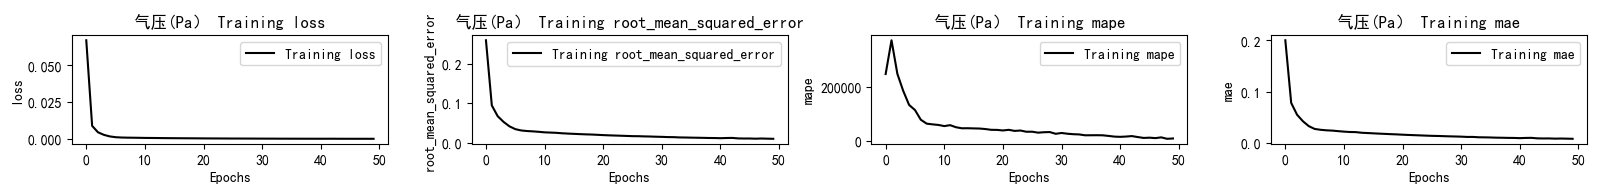

6/6 [==============================] - 1s 9ms/step


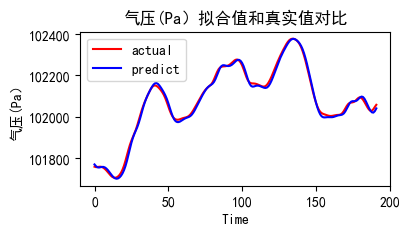

运行时间为32.152
气压(Pa）变量的预测效果为：MAE:8.592,RMSE:10.262,MAPE:0.002,R2:0.996,SCORE:0.089
正在处理变量：相对湿度（%）


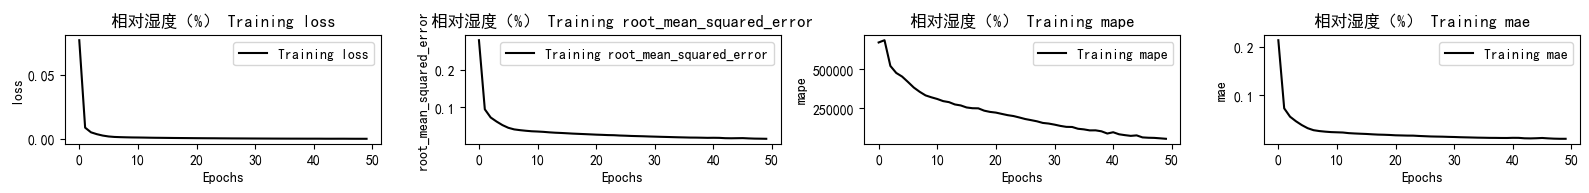

6/6 [==============================] - 1s 10ms/step


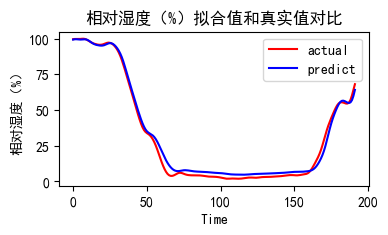

运行时间为31.067
相对湿度（%）变量的预测效果为：MAE:2.525,RMSE:3.079,MAPE:5.288,R2:0.993,SCORE:0.245
正在处理变量：云量


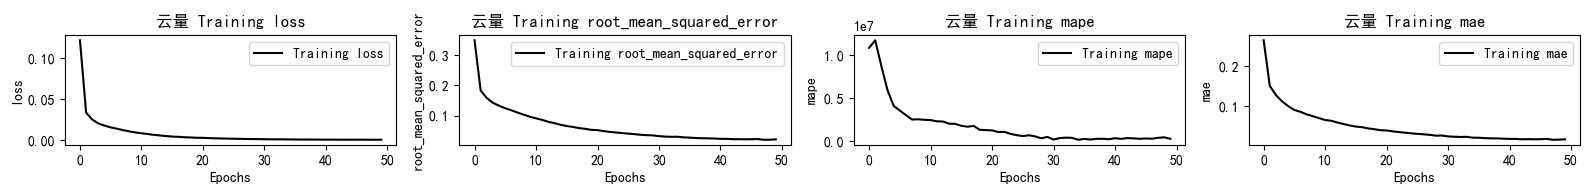

6/6 [==============================] - 1s 11ms/step


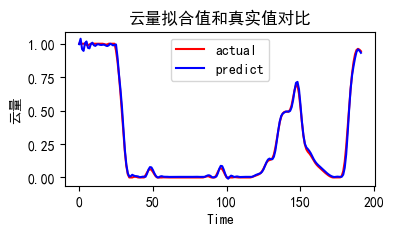

运行时间为31.72
云量变量的预测效果为：MAE:0.01,RMSE:0.014,MAPE:inf,R2:0.999,SCORE:0.986
正在处理变量：10米风速（10m/s）


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


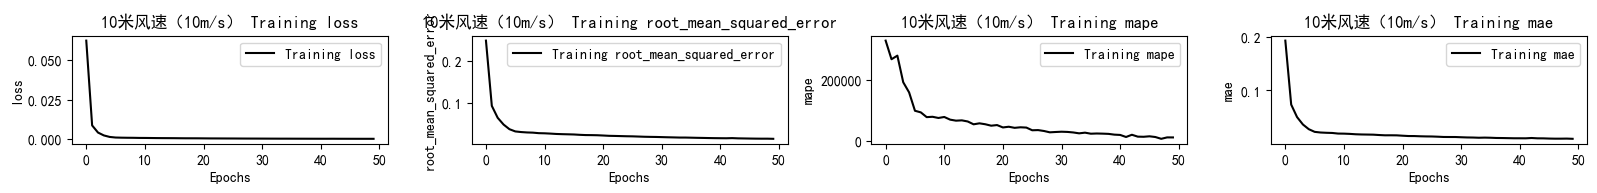

6/6 [==============================] - 1s 10ms/step


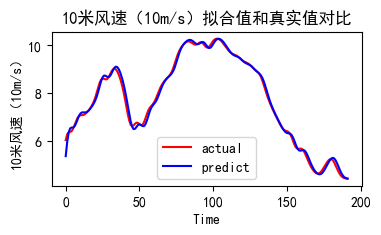

运行时间为31.745
10米风速（10m/s）变量的预测效果为：MAE:0.09,RMSE:0.126,MAPE:0.29,R2:0.995,SCORE:0.888
正在处理变量：10米风向（°)


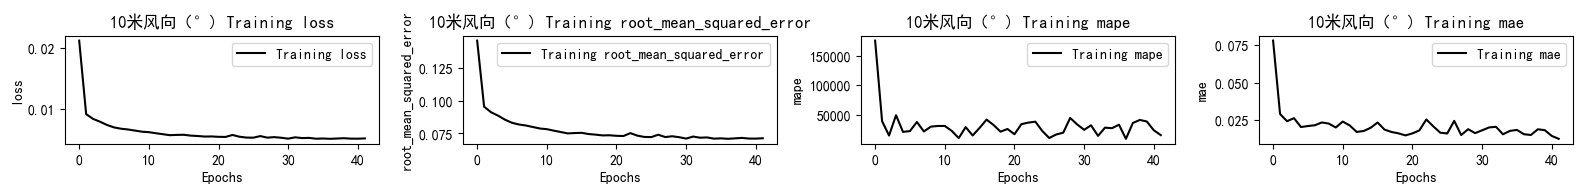

6/6 [==============================] - 1s 10ms/step


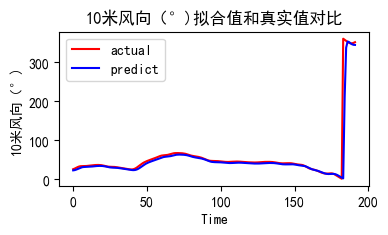

运行时间为29.053
10米风向（°)变量的预测效果为：MAE:5.329,RMSE:28.016,MAPE:1.002,R2:0.826,SCORE:0.034
正在处理变量：温度（K）


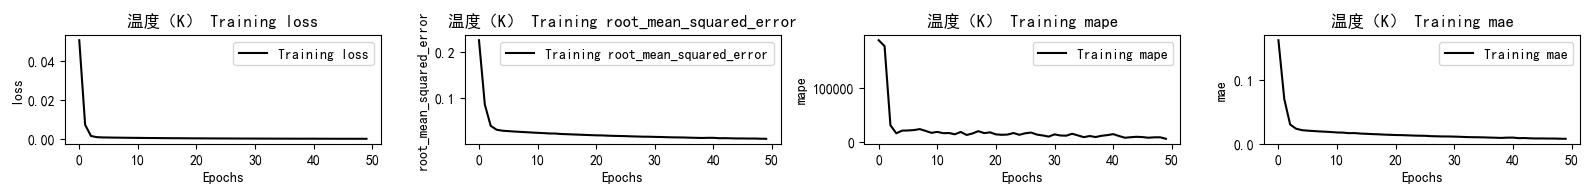

6/6 [==============================] - 1s 9ms/step


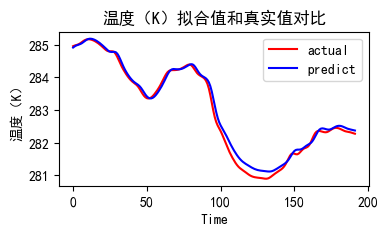

运行时间为32.108
温度（K）变量的预测效果为：MAE:0.104,RMSE:0.139,MAPE:0.006,R2:0.99,SCORE:0.878
正在处理变量：辐照强度（J/m2）


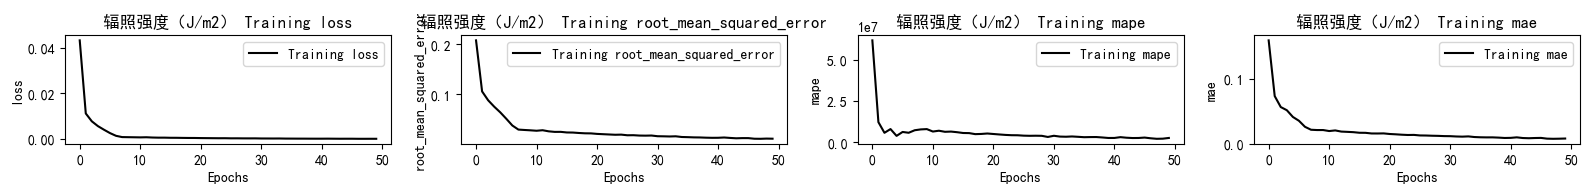

6/6 [==============================] - 1s 12ms/step


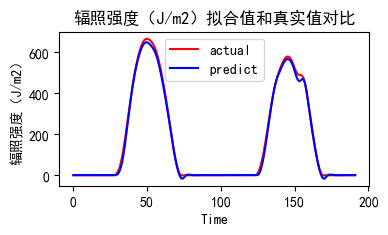

运行时间为32.723
辐照强度（J/m2）变量的预测效果为：MAE:6.639,RMSE:10.057,MAPE:inf,R2:0.998,SCORE:0.09
正在处理变量：降水（m）
降水调用lstm..............


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


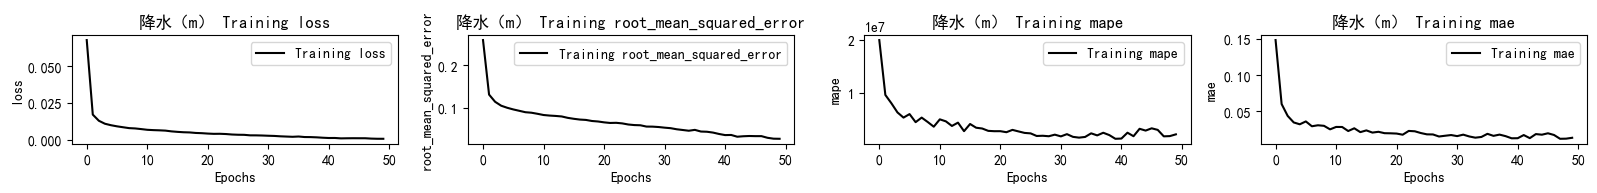

6/6 [==============================] - 1s 12ms/step


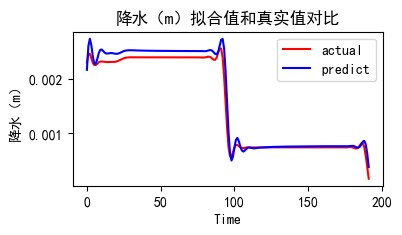

运行时间为36.397
降水（m）变量的预测效果为：MAE:0.0,RMSE:0.0,MAPE:0.861,R2:0.978,SCORE:1.0
正在处理变量：100m风速（100m/s）


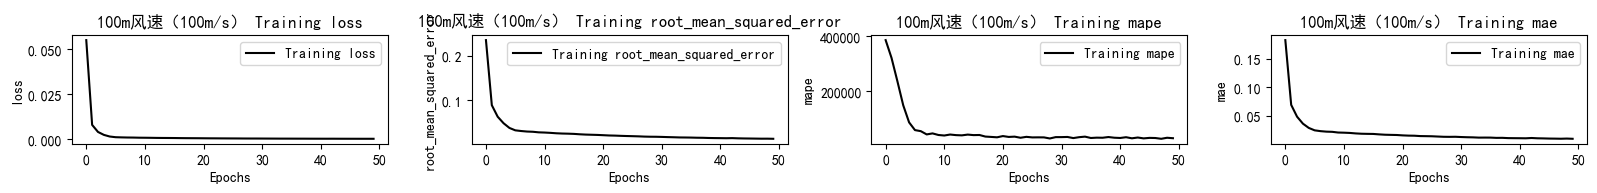

6/6 [==============================] - 1s 10ms/step


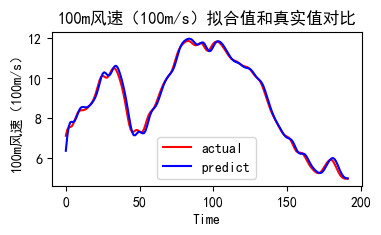

运行时间为32.287
100m风速（100m/s）变量的预测效果为：MAE:0.108,RMSE:0.148,MAPE:0.305,R2:0.995,SCORE:0.871
正在处理变量：100m风向（°)


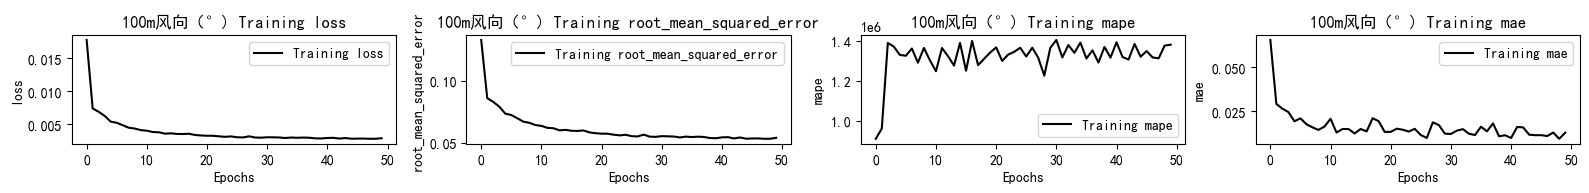

6/6 [==============================] - 1s 11ms/step


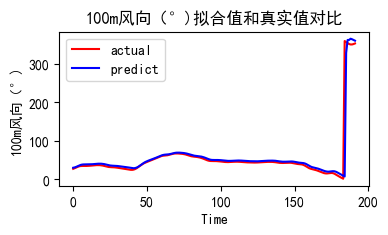

运行时间为31.782
100m风向（°)变量的预测效果为：MAE:5.742,RMSE:25.825,MAPE:1.104,R2:0.837,SCORE:0.037
正在处理变量：y


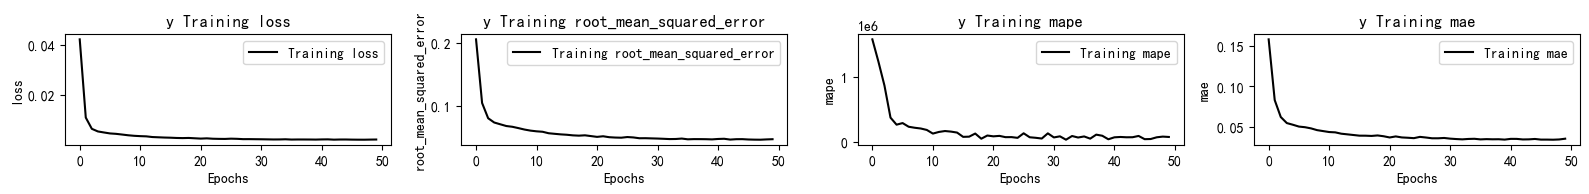

6/6 [==============================] - 1s 10ms/step


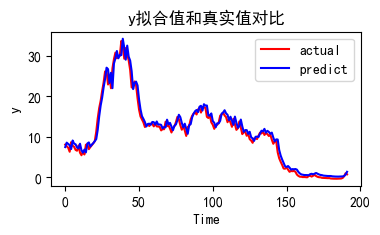

运行时间为30.852
y变量的预测效果为：MAE:1.027,RMSE:1.331,MAPE:9.117,R2:0.973,SCORE:0.429
[1.2179360517339257, 1.5434725323931728, 0.5718728755650585, 0.9643276227324292, 0.3931632786531775]


In [30]:
# =====================2========================================== 
mode='GRU' 
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim)

正在处理变量：气压(Pa）


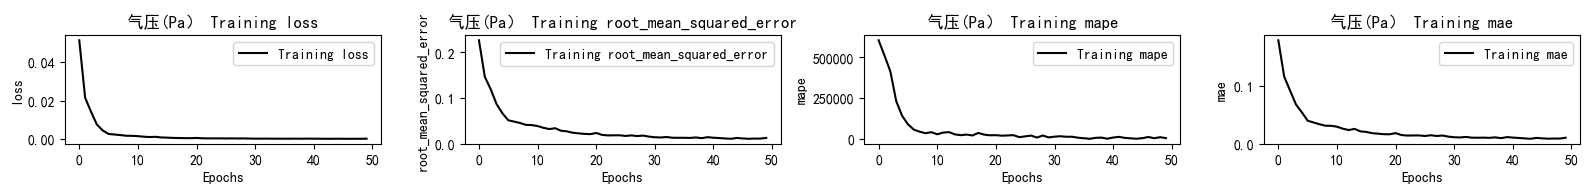

6/6 [==============================] - 0s 3ms/step


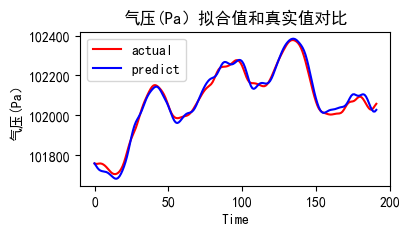

运行时间为9.996
气压(Pa）变量的预测效果为：MAE:15.052,RMSE:18.029,MAPE:0.002,R2:0.988,SCORE:0.053
正在处理变量：相对湿度（%）


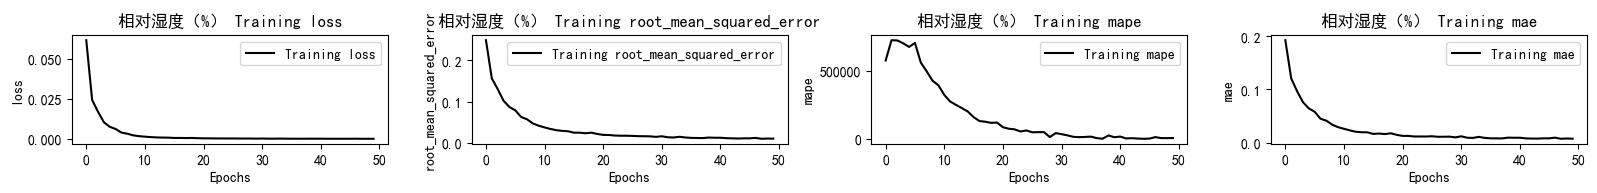

6/6 [==============================] - 0s 4ms/step


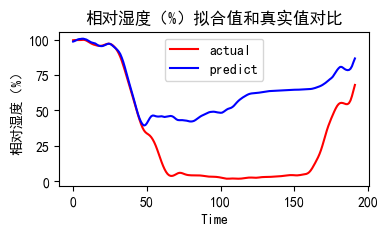

运行时间为8.003
相对湿度（%）变量的预测效果为：MAE:33.44,RMSE:40.466,MAPE:10.463,R2:-0.264,SCORE:0.024
正在处理变量：云量


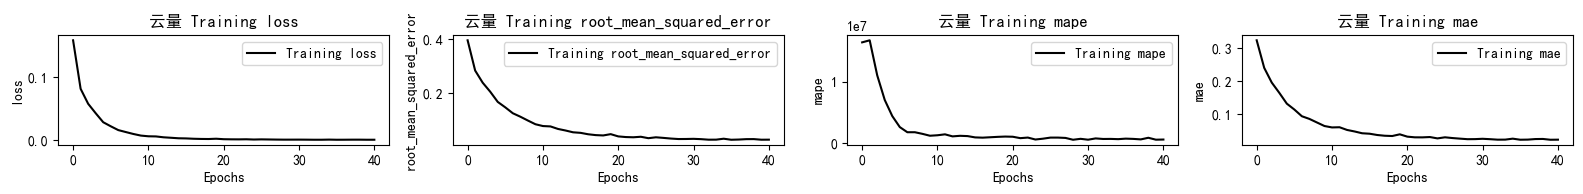

6/6 [==============================] - 0s 3ms/step


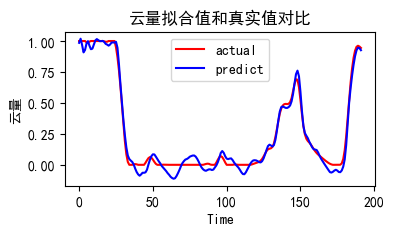

运行时间为6.767
云量变量的预测效果为：MAE:0.037,RMSE:0.045,MAPE:inf,R2:0.986,SCORE:0.957
正在处理变量：10米风速（10m/s）


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


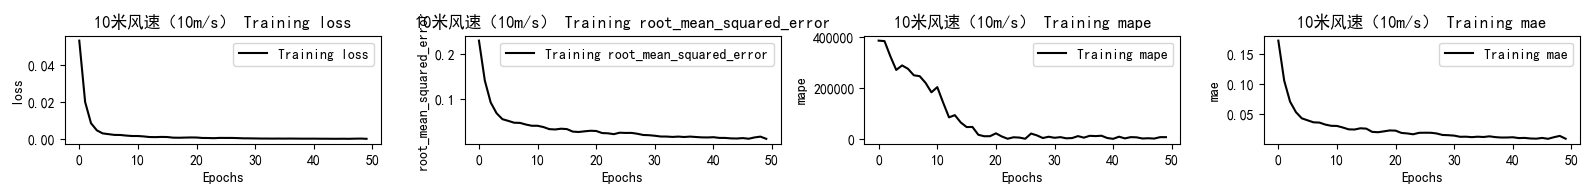

6/6 [==============================] - 0s 3ms/step


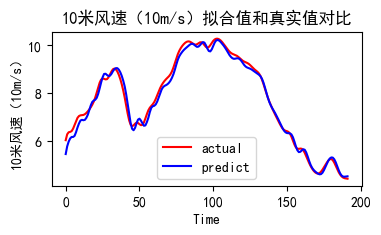

运行时间为7.891
10米风速（10m/s）变量的预测效果为：MAE:0.145,RMSE:0.183,MAPE:0.286,R2:0.989,SCORE:0.845
正在处理变量：10米风向（°)


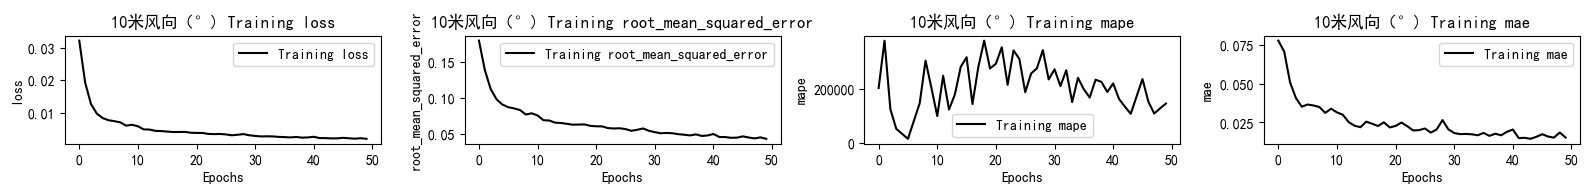

6/6 [==============================] - 0s 4ms/step


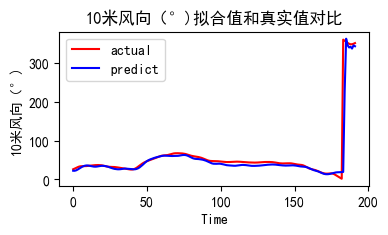

运行时间为8.975
10米风向（°)变量的预测效果为：MAE:6.814,RMSE:26.837,MAPE:0.99,R2:0.84,SCORE:0.036
正在处理变量：温度（K）


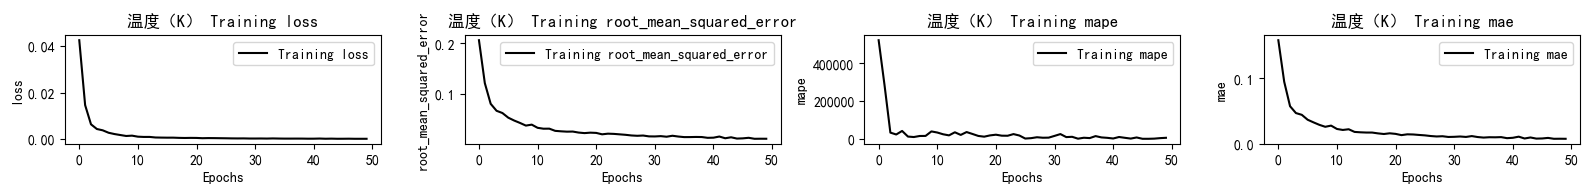

6/6 [==============================] - 0s 3ms/step


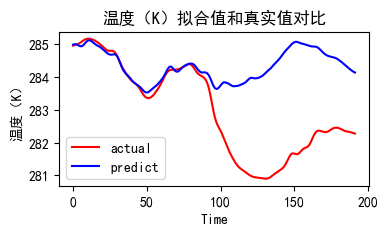

运行时间为8.428
温度（K）变量的预测效果为：MAE:1.364,RMSE:1.916,MAPE:0.006,R2:-0.892,SCORE:0.343
正在处理变量：辐照强度（J/m2）


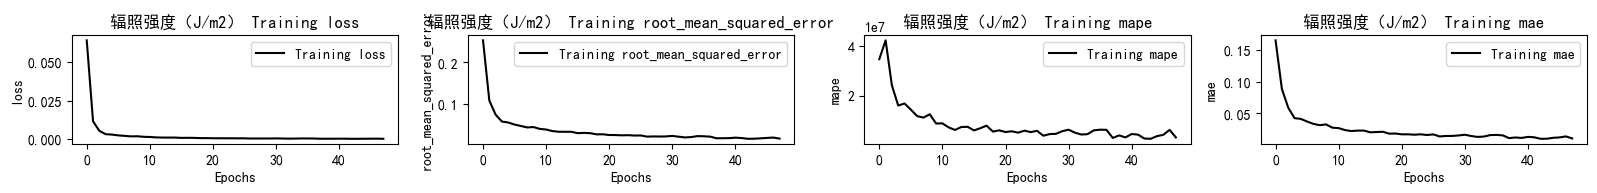

6/6 [==============================] - 0s 3ms/step


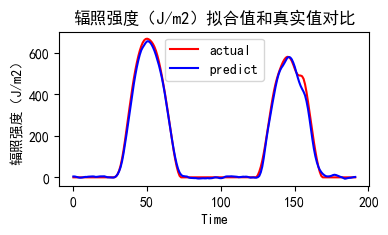

运行时间为7.786
辐照强度（J/m2）变量的预测效果为：MAE:9.853,RMSE:14.81,MAPE:inf,R2:0.996,SCORE:0.063
正在处理变量：降水（m）
降水调用lstm..............


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


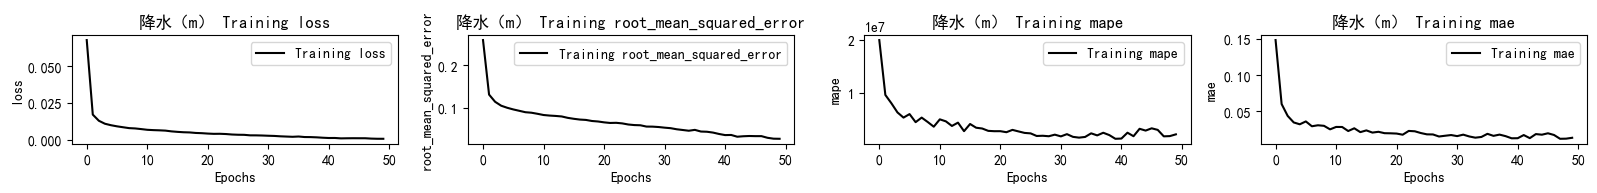

6/6 [==============================] - 1s 12ms/step


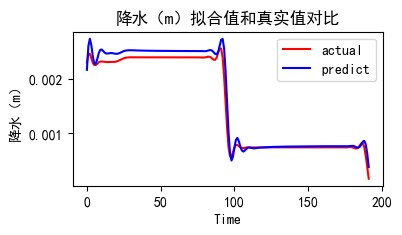

运行时间为35.365
降水（m）变量的预测效果为：MAE:0.0,RMSE:0.0,MAPE:0.861,R2:0.978,SCORE:1.0
正在处理变量：100m风速（100m/s）


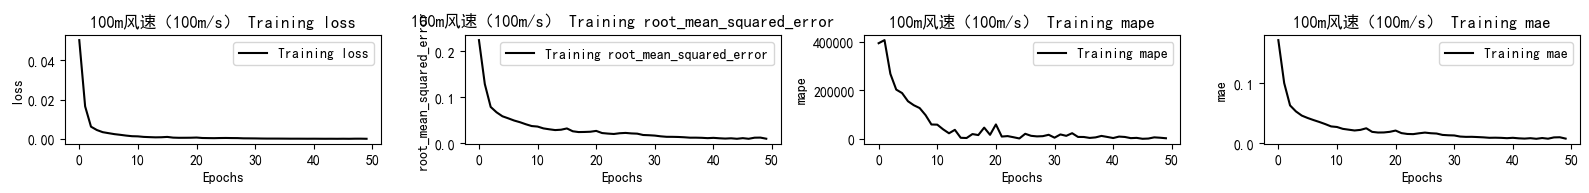

6/6 [==============================] - 0s 4ms/step


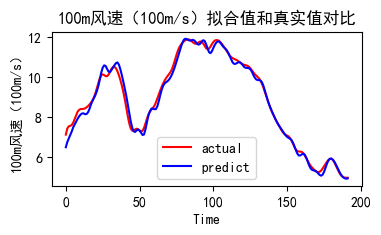

运行时间为8.393
100m风速（100m/s）变量的预测效果为：MAE:0.157,RMSE:0.219,MAPE:0.305,R2:0.989,SCORE:0.82
正在处理变量：100m风向（°)


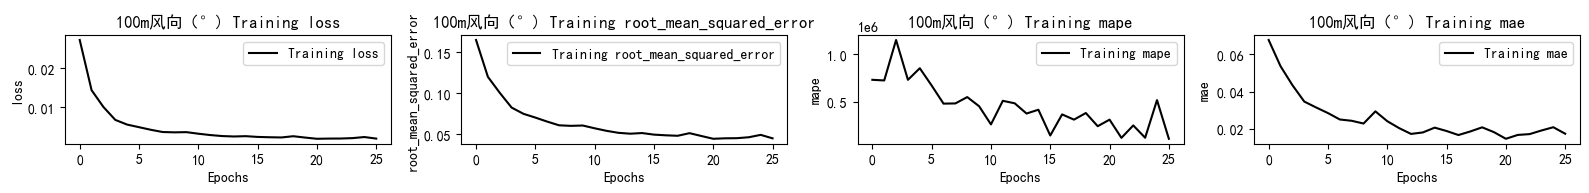

6/6 [==============================] - 0s 4ms/step


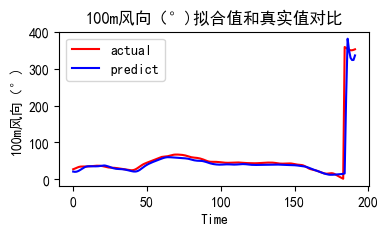

运行时间为5.406
100m风向（°)变量的预测效果为：MAE:7.184,RMSE:27.271,MAPE:0.974,R2:0.818,SCORE:0.035
正在处理变量：y


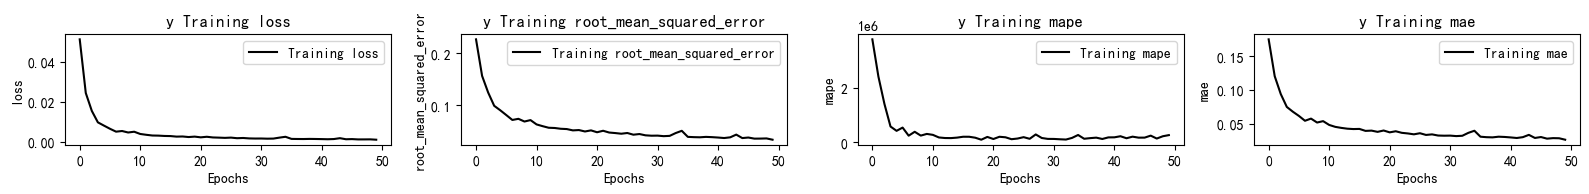

6/6 [==============================] - 0s 4ms/step


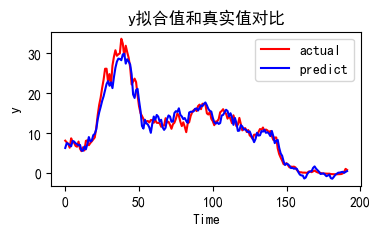

运行时间为8.619
y变量的预测效果为：MAE:1.185,RMSE:1.629,MAPE:8.665,R2:0.96,SCORE:0.38
[6.091077687387183, 7.591026929938374, 3.890399756693858, 0.1371499943066864, 0.11640051976966315]


In [31]:

mode='CNN' 
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=batch_size,epochs=epochs,hidden_dim=hidden_dim)

正在处理变量：气压(Pa）


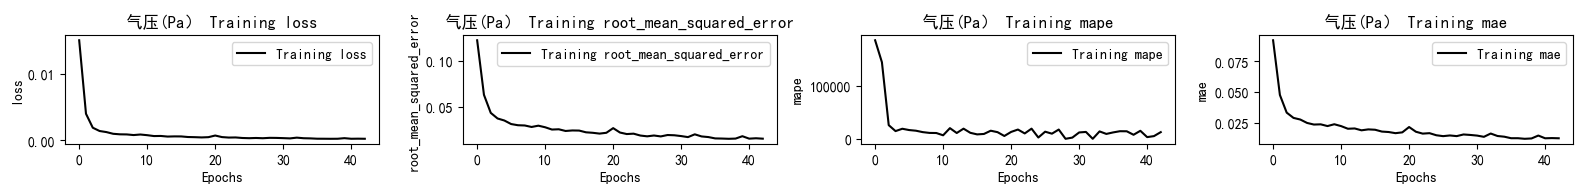

6/6 [==============================] - 0s 1ms/step


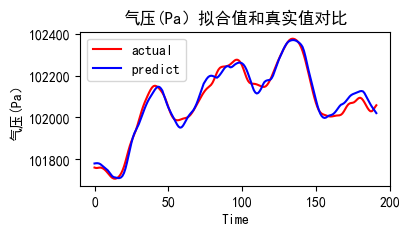

运行时间为4.307
气压(Pa）变量的预测效果为：MAE:18.654,RMSE:23.148,MAPE:0.002,R2:0.981,SCORE:0.041
正在处理变量：相对湿度（%）


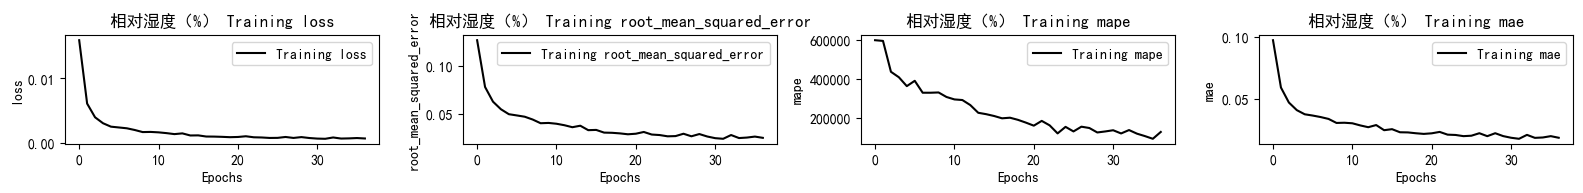

6/6 [==============================] - 0s 1ms/step


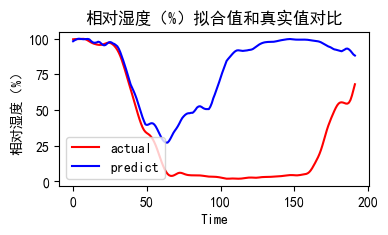

运行时间为2.441
相对湿度（%）变量的预测效果为：MAE:47.429,RMSE:59.909,MAPE:12.844,R2:-1.771,SCORE:0.016
正在处理变量：云量


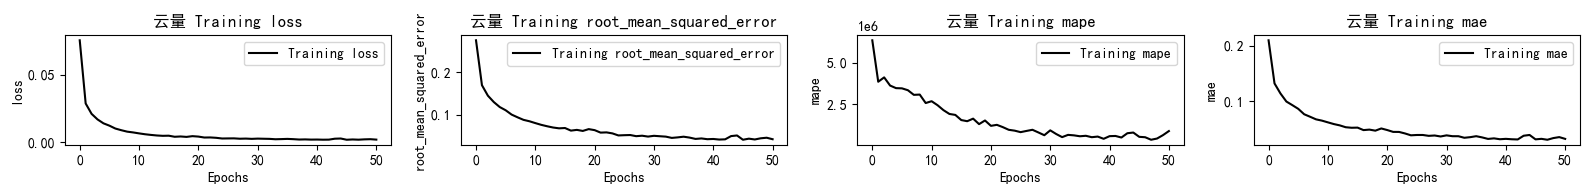

6/6 [==============================] - 0s 2ms/step


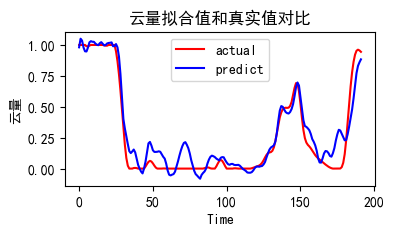

运行时间为2.862
云量变量的预测效果为：MAE:0.073,RMSE:0.1,MAPE:inf,R2:0.928,SCORE:0.909
正在处理变量：10米风速（10m/s）


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


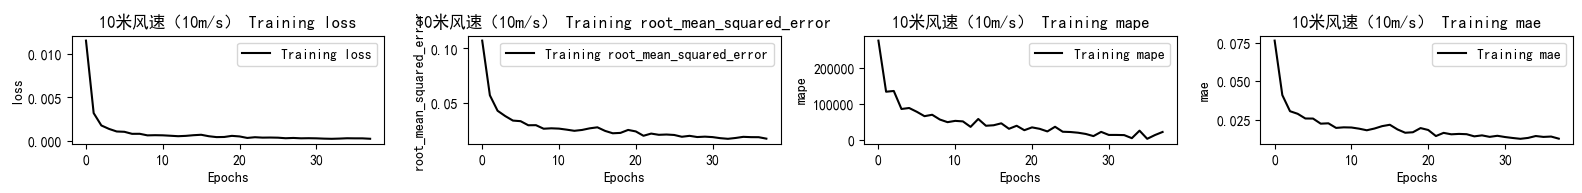

6/6 [==============================] - 0s 1ms/step


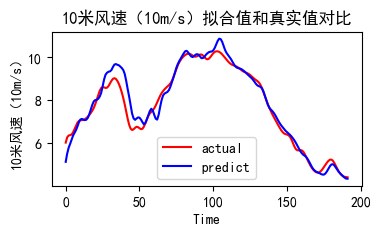

运行时间为2.916
10米风速（10m/s）变量的预测效果为：MAE:0.251,RMSE:0.384,MAPE:0.3,R2:0.953,SCORE:0.722
正在处理变量：10米风向（°)


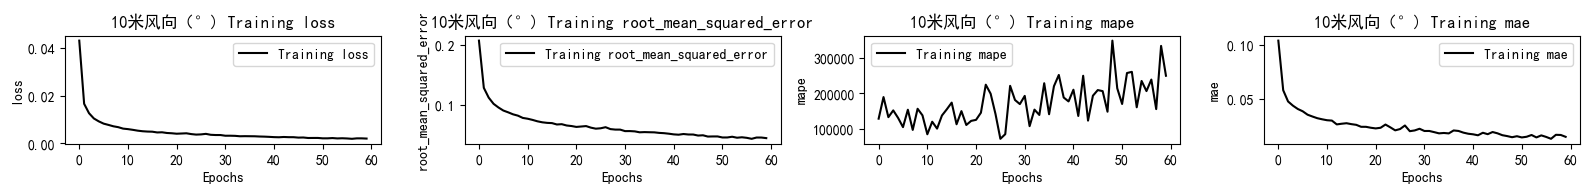

6/6 [==============================] - 0s 1ms/step


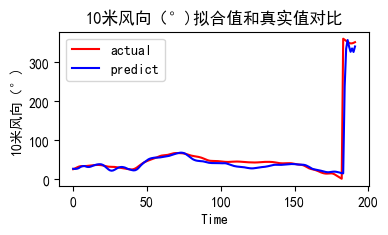

运行时间为3.136
10米风向（°)变量的预测效果为：MAE:7.782,RMSE:27.247,MAPE:0.982,R2:0.835,SCORE:0.035
正在处理变量：温度（K）


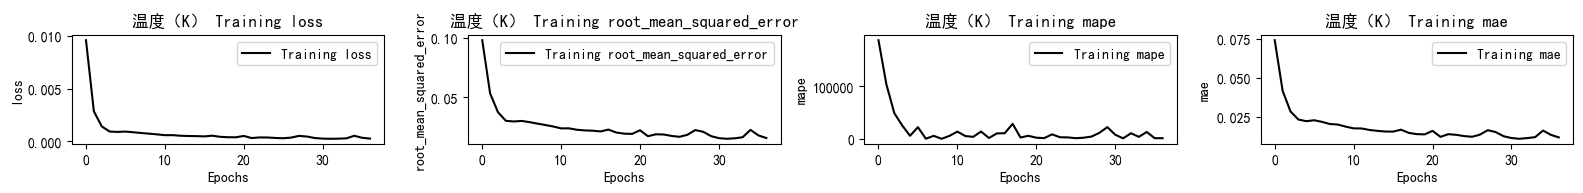

6/6 [==============================] - 0s 1ms/step


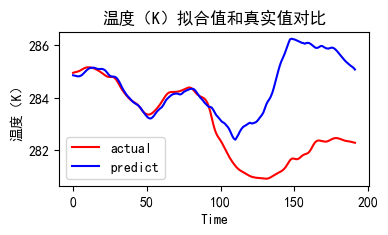

运行时间为2.431
温度（K）变量的预测效果为：MAE:1.506,RMSE:2.23,MAPE:0.007,R2:-1.562,SCORE:0.31
正在处理变量：辐照强度（J/m2）


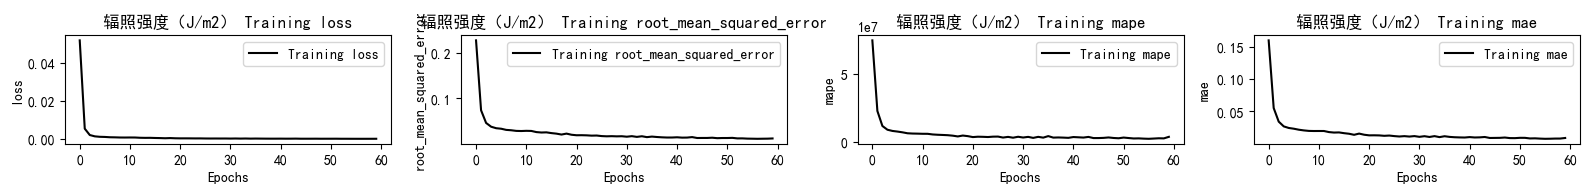

6/6 [==============================] - 0s 1ms/step


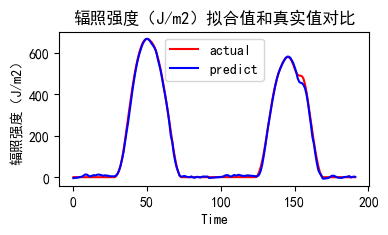

运行时间为3.163
辐照强度（J/m2）变量的预测效果为：MAE:6.457,RMSE:8.859,MAPE:inf,R2:0.999,SCORE:0.101
正在处理变量：降水（m）
降水调用lstm..............


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_40320\786894615.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


ValueError: in user code:

    File "E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "E:\Anaconda\envs\recbyhand_pytorch\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_73" is incompatible with the layer: expected shape=(None, 704, 64), found shape=(32, 64)


In [32]:

mode='MLP' 
set_my_seed()
train_fuc(mode=mode,window_size=window_size,batch_size=batch_size,epochs=60,hidden_dim=hidden_dim)